In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found

all_classes = Base.classes.keys()

all_classes

['station', 'measurement']

In [7]:
# Save references to each table

measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

most_recent_date = session.query(func.max(measurement.date)).scalar()

most_recent_date


'2017-08-23'

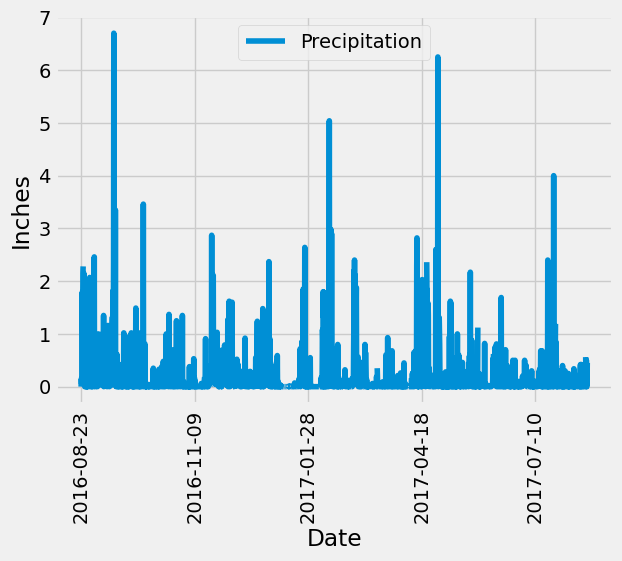

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_date

# Calculate the date one year from the last date in data set.

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

results = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date >= one_year_ago)
    .order_by(measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(x = 'Date', y = 'Precipitation', rot = 90)
plt.xlabel('Date')
plt.ylabel('Inches')

plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_statistics = precipitation_df['Precipitation'].describe()

summary_statistics_df = pd.DataFrame(summary_statistics)

summary_statistics_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(station.station)).scalar()

total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station).label('station_count'))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).label('station_count').desc()).all()

active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Observation Count'])

active_stations_df

,Station,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations_df['Station'].iloc[0]

temperature_stats = session.query(func.min(measurement.tobs).label('lowest_temperature'),
                                 func.max(measurement.tobs).label('highest_temperature'),
                                 func.avg(measurement.tobs).label('average_temperature'))\
    .filter(measurement.station == most_active_station).all()


                               
print(f"Temperature statistics from the most active station ({most_active_station}):")

print(f"Lowest Temperature: {temperature_stats[0].lowest_temperature}°F")

print(f"Highest Temperature: {temperature_stats[0].highest_temperature}°F")

print(f"Average Temperature: {temperature_stats[0].average_temperature}°F")

Temperature statistics from the most active station (USC00519281):
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66378066378067°F


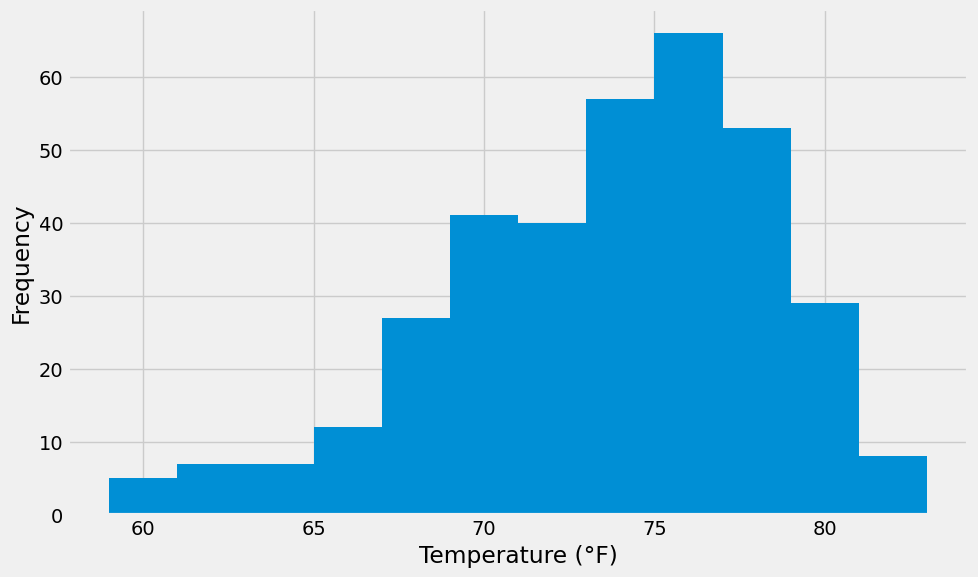

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = (
    session.query(measurement.date, measurement.tobs)
    .filter(measurement.station == most_active_station, measurement.date >= one_year_ago)
    .all()
)          

temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])



plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()

# Close Session

In [16]:
# Close Session
session.close()